In [1]:
import scvelo as scv

ldata=scv.read("velo/adata_velo_raw.h5ad")
adata=scv.read("data/adata_processed.h5ad")
adata=scv.utils.merge(adata,ldata)
adata.obsp=None
del adata.uns["neighbors"]

In [2]:
adata

AnnData object with n_obs × n_vars = 8842 × 20559
    obs: 'plates', 'devtime', 'location', 'n_genes_by_counts', 'total_counts', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'leiden', 'CytoTRACE', 'batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'devtime_colors', 'leiden', 'leiden_colors', 'leiden_sizes', 'location_colors', 'log1p', 'paga', 'umap'
    obsm: 'X_diff', 'X_pca', 'X_umap'
    layers: 'palantir_imp', 'scaled', 'ambiguous', 'matrix', 'spanning', 'spliced', 'unspliced'

In [3]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
adata.write("velo/adata_tobrie.h5ad")
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 3759 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:23) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [4]:
import pandas as pd
df = pd.DataFrame(adata.obs["CytoTRACE"],index=adata.obs_names).to_csv("velo/cell_info_cytotrace.tsv",sep="\t")

Run the following command in bash:
```bash
brie-quant -i velo/adata_tobrie.h5ad -o velo/brie_cytotrace.h5ad -c velo/cell_info_cytotrace.tsv --layers=spliced,unspliced --interceptMode gene --batchSize 1000000 --LRTindex All
```

computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/88 cores)


  0%|          | 0/8842 [00:00<?, ?cells/s]

    finished (0:00:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


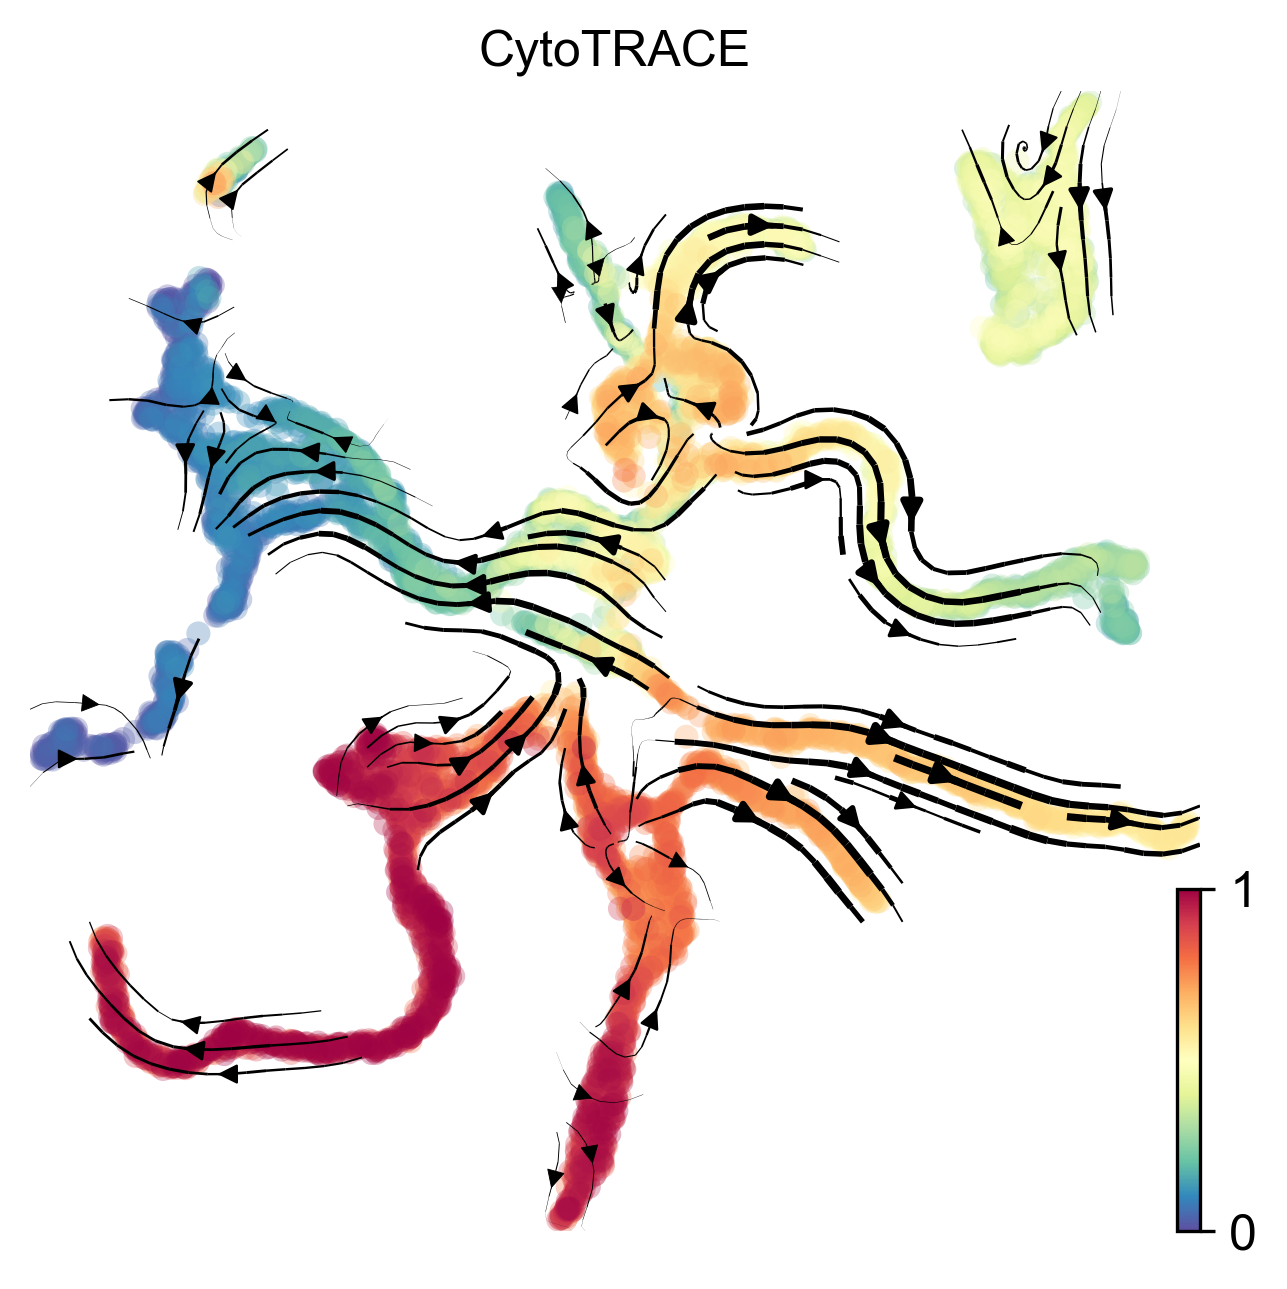

In [5]:
scv.set_figure_params('scvelo',figsize=(5,5),dpi=150) 
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap',color="CytoTRACE",cmap="Spectral_r")

In [6]:
adata=scv.read("velo/brie_cytotrace.h5ad")

In [7]:
import numpy as np
idx = (np.min(adata.varm['fdr'], axis=1) < 1e-40)
gene_use = adata.var.index[idx]
gene_use

Index(['Prim2', 'Dst', 'Adam23', 'Lrrfip1', 'Fam129a', 'Tfap2b',
       '1500015O10Rik', 'Myl1', 'Ivns1abp', 'Prdx6',
       ...
       'Egfl8', 'Ddr1', 'Ppp2r2b', 'Myo5b', 'Zfp521', 'Nrep', 'Hspa9', 'Plce1',
       'Pygm', 'Hells'],
      dtype='object', length=120)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/88 cores)


  0%|          | 0/8842 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


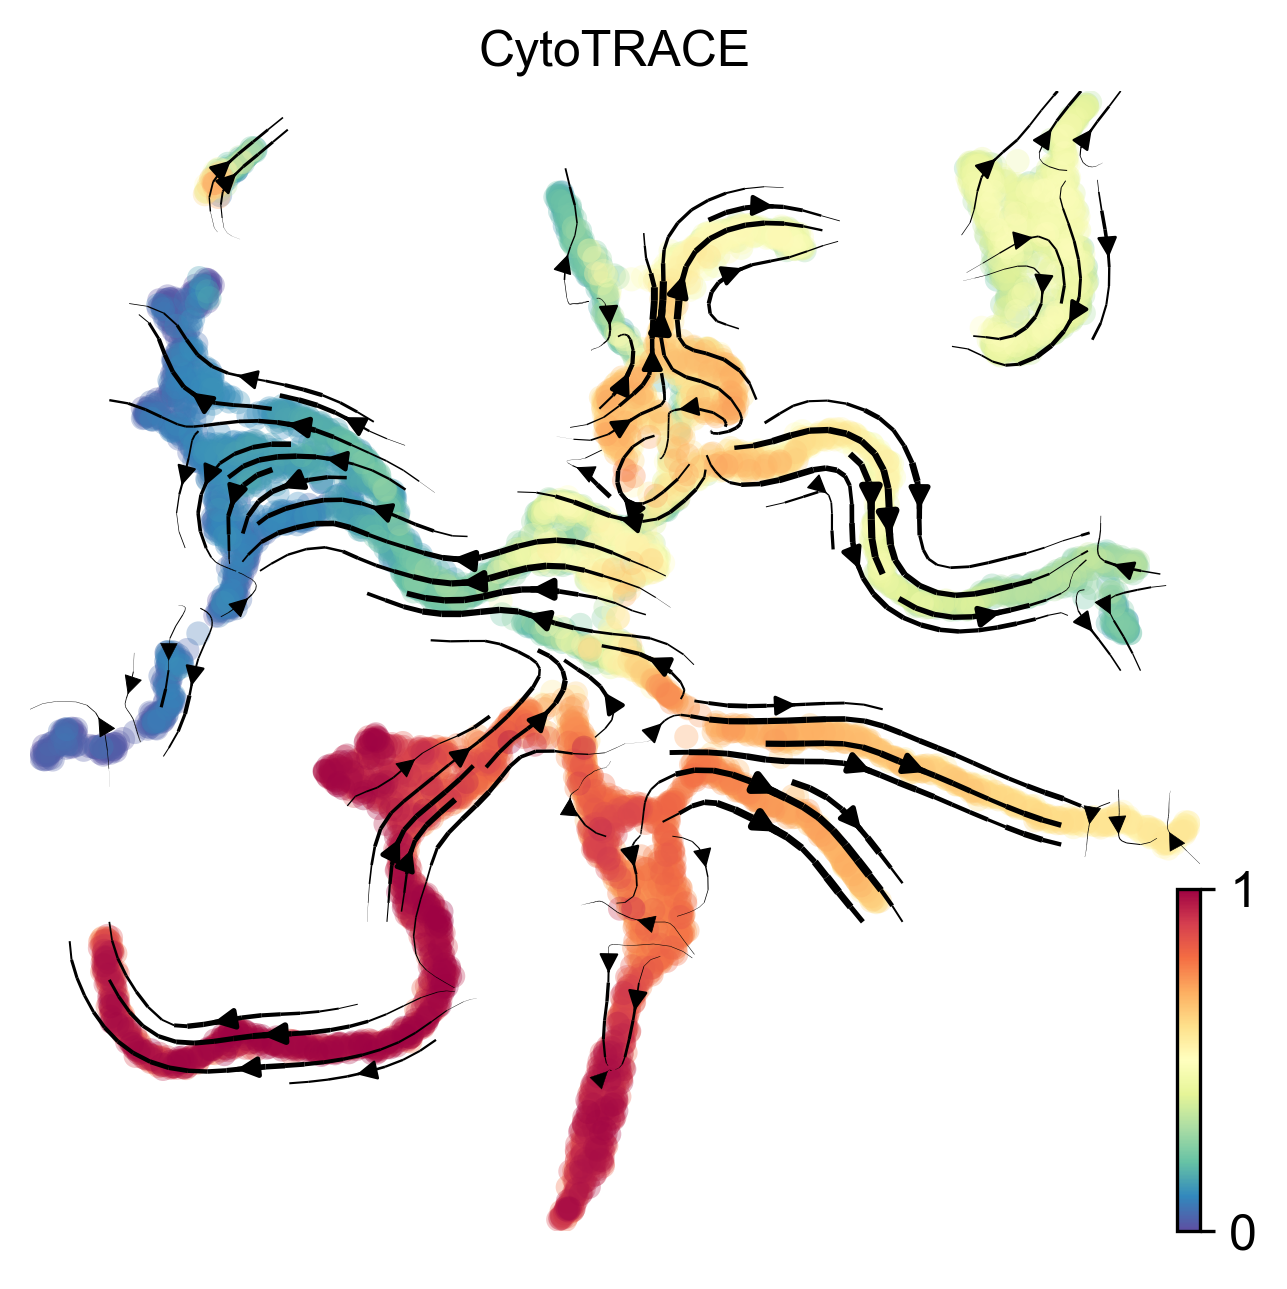

In [8]:
scv.tl.velocity_graph(adata, gene_subset=gene_use)
scv.pl.velocity_embedding_stream(adata, basis='umap',color="CytoTRACE",cmap="Spectral_r",figsize=(5,5),dpi=150)

In [9]:
adata.write("data/adata_velo.h5ad")